--- Starting PHASE I: Explainability (SHAP Analysis) ---
[Setup] Mapping 'lr_model' to 'trained_logreg_model'...
[Setup] X_train not found in globals. Reconstructing using train_test_split(random_state=42)...
[Analysis] Initializing SHAP LinearExplainer...
[Analysis] Computing SHAP values for X_test...

[Plot] Generating Global SHAP Summary Plot...


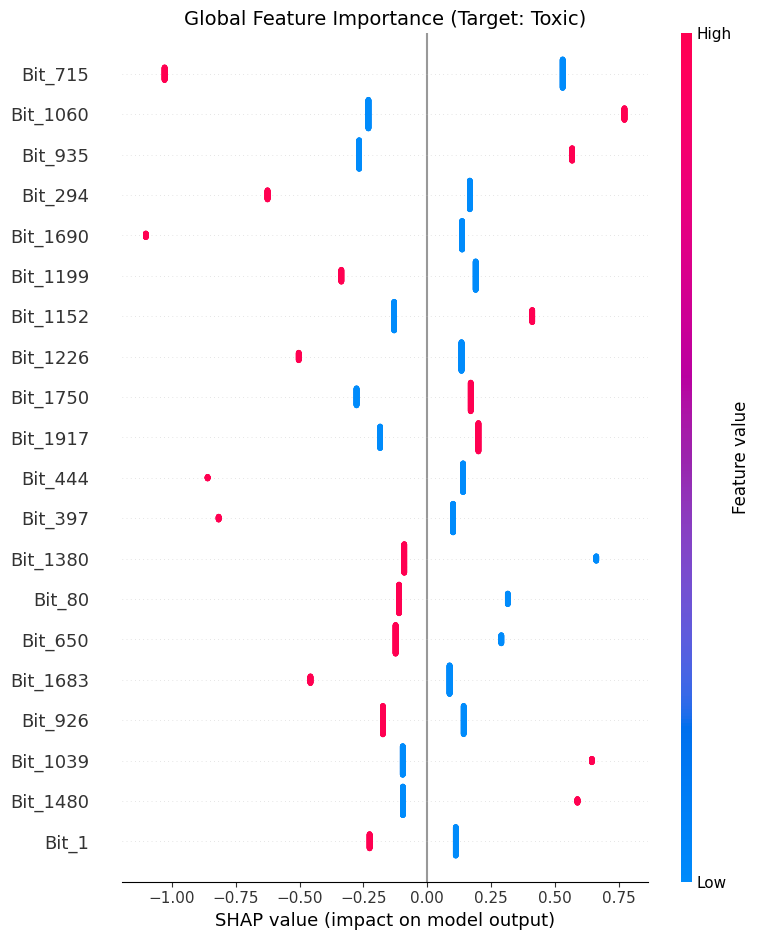


       TOP 10 TOXICITY PREDICTORS (Global)
Rank  | Feature    | Mean |SHAP| 
--------------------------------------------------
1     | Bit_715    | 0.6846
2     | Bit_1060   | 0.3893
3     | Bit_935    | 0.3589
4     | Bit_294    | 0.2791
5     | Bit_1690   | 0.2515
6     | Bit_1199   | 0.2330
7     | Bit_1152   | 0.2141
8     | Bit_1226   | 0.2120
9     | Bit_1750   | 0.2101
10    | Bit_1917   | 0.1934
Interpretation: These bits have the strongest impact (positive or negative)
on the model's decision to classify a molecule as Toxic.

[Case Study A] True Positive (Correctly Predicted Toxic)
 -> Sample Index: 97
 -> Explanation: Positive SHAP values (Red) push the probability HIGHER.


<Figure size 1000x300 with 0 Axes>

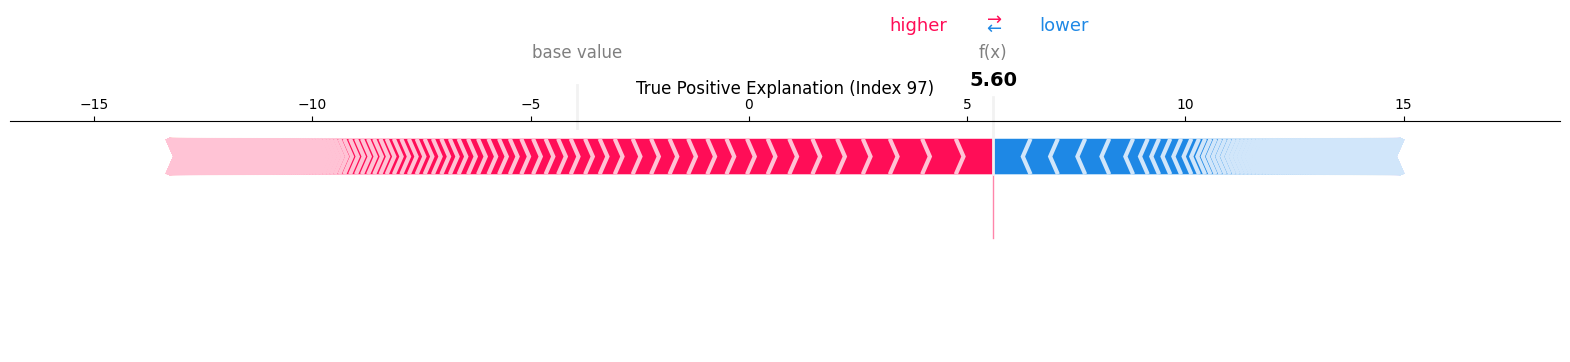


[Case Study B] False Negative (Toxic Missed as Safe)
 -> Sample Index: 29
 -> Explanation: Even though this molecule is Toxic, blue bars (Safe features)
    counteracted the red bars (Toxic features), keeping the score below threshold.


<Figure size 1000x300 with 0 Axes>

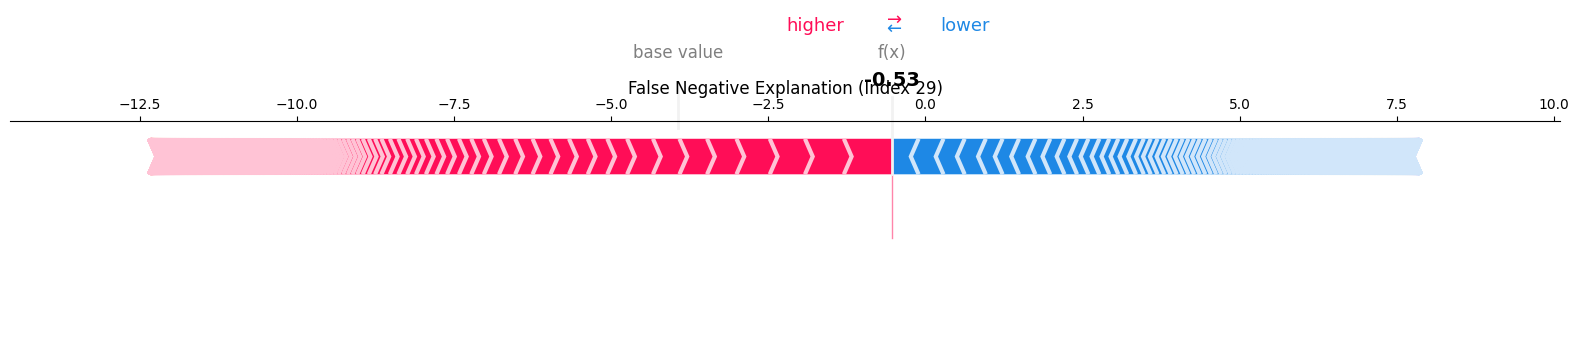


--- PHASE I COMPLETED SUCCESSFULLY ---


In [ ]:
# Install SHAP if not already installed
!pip install shap

import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

def run_phase_i():
    """
    Executes Phase I: Model Explainability using SHAP.
    Generates global and local explanations for the toxicology model.
    """
    print(f"--- Starting PHASE I: Explainability (SHAP Analysis) ---")

    # 1. Defensive Programming & Context Mapping
    # Ensure model exists (mapping Phase F output 'lr_model' to requested 'trained_logreg_model' if needed)
    if 'trained_logreg_model' not in globals():
        if 'lr_model' in globals():
            print(f"[Setup] Mapping 'lr_model' to 'trained_logreg_model'...")
            trained_logreg_model = globals()['lr_model']
        else:
            raise NameError("CRITICAL ERROR: Logistic Regression model not found. Run Phase F first.")
    else:
        trained_logreg_model = globals()['trained_logreg_model']

    # Ensure X_test and y_test exist (Output from Phase F)
    assert 'X_test' in globals(), "CRITICAL ERROR: X_test not found. Run Phase F first."
    assert 'y_test' in globals(), "CRITICAL ERROR: y_test not found. Run Phase F first."

    X_test_local = globals()['X_test']
    y_test_local = globals()['y_test']

    # Reconstruct X_train if missing (Common issue if Phase F didn't export it globally)
    if 'X_train' not in globals():
        print(f"[Setup] X_train not found in globals. Reconstructing using train_test_split(random_state=42)...")
        if 'X' in globals() and 'y' in globals():
            X_global = globals()['X']
            y_global = globals()['y']
            # Re-create split identical to Phase F to get the correct X_train
            X_train_local, _, _, _ = train_test_split(
                X_global, y_global,
                test_size=0.20,
                stratify=y_global,
                random_state=42
            )
        else:
             raise NameError("CRITICAL ERROR: Global X and y not found to reconstruct X_train.")
    else:
        X_train_local = globals()['X_train']

    # 2. Setup Feature Names
    # Morgan fingerprints don't have intrinsic names, so we label them by bit index
    feature_names = [f"Bit_{i}" for i in range(X_test_local.shape[1])]

    # 3. Initialize SHAP LinearExplainer
    print(f"[Analysis] Initializing SHAP LinearExplainer...")
    # Masker is useful for Linear models to define the background distribution
    # We use a subset of X_train for the masker to keep it efficient
    masker = shap.maskers.Independent(X_train_local, max_samples=100)
    explainer = shap.LinearExplainer(trained_logreg_model, masker=masker)

    # 4. Compute SHAP values for Test Set
    print(f"[Analysis] Computing SHAP values for X_test...")
    shap_values = explainer.shap_values(X_test_local)

    # Handle SHAP output format (LinearExplainer for binary often returns a list [class0, class1])
    # We focus on Class 1 (Toxic)
    if isinstance(shap_values, list):
        shap_values_toxic = shap_values[1]
    else:
        shap_values_toxic = shap_values  # Some versions might return just the array for binary

    # 5. Global Explanation: Summary Plot
    print(f"\n[Plot] Generating Global SHAP Summary Plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_toxic, X_test_local, feature_names=feature_names, plot_type="dot", show=False)
    plt.title("Global Feature Importance (Target: Toxic)", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 6. Top 10 Features Report
    print(f"\n" + "="*50)
    print(f"       TOP 10 TOXICITY PREDICTORS (Global)")
    print(f"="*50)
    # Calculate mean absolute SHAP value for each feature
    mean_abs_shap = np.abs(shap_values_toxic).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]

    print(f"{'Rank':<5} | {'Feature':<10} | {'Mean |SHAP|':<12}")
    print(f"-"*50)
    for i, idx in enumerate(top_indices):
        print(f"{i+1:<5} | {feature_names[idx]:<10} | {mean_abs_shap[idx]:.4f}")
    print(f"="*50)
    print(f"Interpretation: These bits have the strongest impact (positive or negative)\n"
          f"on the model's decision to classify a molecule as Toxic.")

    # 7. Local Explanations
    # Get predictions to find specific cases
    y_pred = trained_logreg_model.predict(X_test_local)

    # Identify indices for specific cases
    # True Positive: Actual=1, Pred=1
    tp_indices = np.where((y_test_local == 1) & (y_pred == 1))[0]
    # False Negative: Actual=1, Pred=0
    fn_indices = np.where((y_test_local == 1) & (y_pred == 0))[0]

    # --- Case A: True Positive ---
    if len(tp_indices) > 0:
        idx_tp = tp_indices[0]
        print(f"\n[Case Study A] True Positive (Correctly Predicted Toxic)")
        print(f" -> Sample Index: {idx_tp}")
        print(f" -> Explanation: Positive SHAP values (Red) push the probability HIGHER.")

        plt.figure(figsize=(10, 3))
        # force_plot with matplotlib=True generates a static image suitable for Colab
        shap.force_plot(
            explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            shap_values_toxic[idx_tp],
            X_test_local[idx_tp],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"True Positive Explanation (Index {idx_tp})", fontsize=12, pad=20)
        plt.show()
    else:
        print(f"\n[Case Study A] No True Positives found in test set to explain.")

    # --- Case B: False Negative ---
    if len(fn_indices) > 0:
        idx_fn = fn_indices[0]
        print(f"\n[Case Study B] False Negative (Toxic Missed as Safe)")
        print(f" -> Sample Index: {idx_fn}")
        print(f" -> Explanation: Even though this molecule is Toxic, blue bars (Safe features)")
        print(f"    counteracted the red bars (Toxic features), keeping the score below threshold.")

        plt.figure(figsize=(10, 3))
        shap.force_plot(
            explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            shap_values_toxic[idx_fn],
            X_test_local[idx_fn],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"False Negative Explanation (Index {idx_fn})", fontsize=12, pad=20)
        plt.show()
    else:
        print(f"\n[Case Study B] No False Negatives found in test set to explain.")

# --- EXECUTION ---
run_phase_i()

print(f"\n--- PHASE I COMPLETED SUCCESSFULLY ---")